# MCMC sampling functionality using simulated data

A not-very-polished demonstration of Markov chain Monte Carlo (MCMC) sampling for estimation of volume and pose variables in an ab-initio manner, in the spirit of [Lederman et al, 2020](https://iopscience.iop.org/article/10.1088/1361-6420/ab5ede/meta), although only for homogeneous reconstruction.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
from jax import config
import time
import mrcfile
from pyem import star

from simplecryoem.ab_initio import ab_initio_mcmc
from simplecryoem.forwardmodel import (
    project,
    apply_shifts_and_ctf,
    Slice,
    rotate_and_interpolate,
)
from simplecryoem.optimization import (
    Loss,
    GradV,
    sgd,
    get_sgd_vol_ops,
    conjugate_gradient,
    get_cg_vol_ops,
)
from simplecryoem.sampling import mcmc_sampling, proposal_hmc, CryoProposals
from simplecryoem.fsc import calc_fsc, shell_points_used, points_orientations_tri
from simplecryoem.utils import (
    volume_fourier,
    volume_comp,
    mip_y,
    mip_z,
    create_3d_mask,
    generate_uniform_orientations,
    generate_uniform_orientations_jax,
    generate_gaussian_shifts,
    generate_uniform_shifts,
    crop_fourier_images,
    crop_fourier_volume,
    plot_angles,
    wrap_around_distance_2d_array,
)

2024-10-12 16:28:37.478578: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

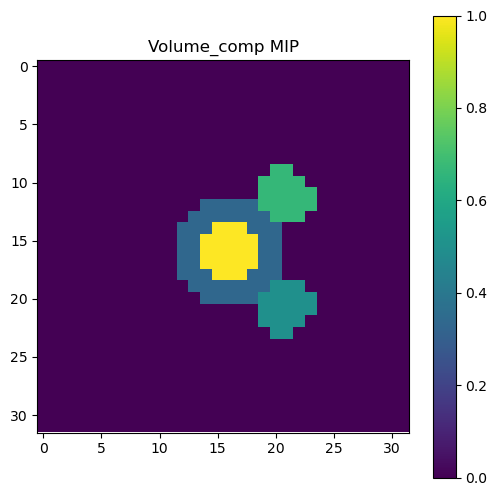

In [3]:
nx = 32
shape = np.array([nx, nx, nx])
dimensions = np.array([20, 20, 20])
pixel_size = dimensions[0] / shape[0]

# A volume with components
centres = np.array([[0, 0, 0], [3, 3, 0], [3, -3, 0], [0, 0, 3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10, 15, 20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
# plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title("Volume_comp MIP")

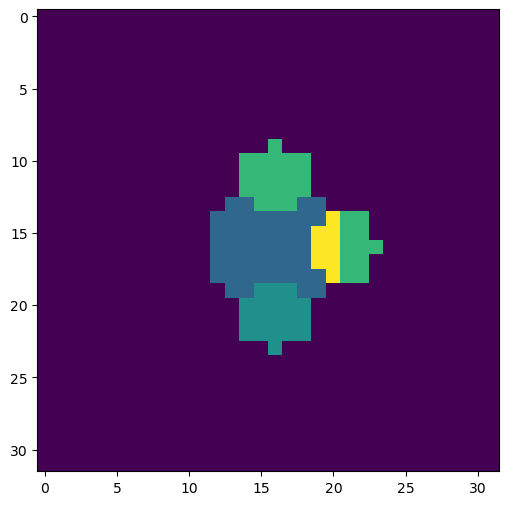

In [4]:
mip_y(vol)

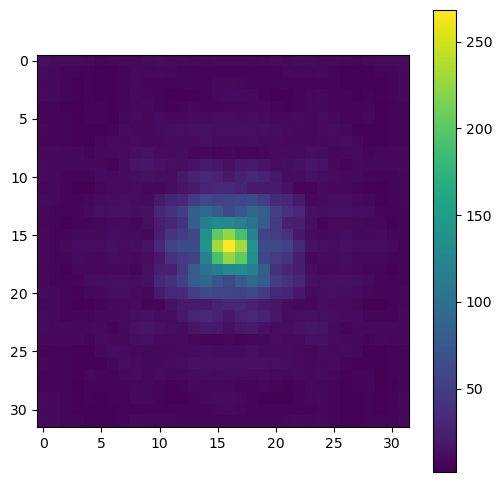

In [5]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier))))
plt.colorbar()

### Generate the data

CTF

In [6]:
df = star.parse_star("comparisons/data/pyem.star", keep_index=False)
dfiter = df.iterrows()
_, p = next(dfiter)

# ctf_params = {'def1'  : p[star.Relion.DEFOCUSU],
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE],
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC],
#              'cs'    : p[star.Relion.CS],
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array(
    [
        p[star.Relion.DEFOCUSU],
        p[star.Relion.DEFOCUSV],
        p[star.Relion.DEFOCUSANGLE],
        p[star.Relion.PHASESHIFT],
        p[star.Relion.VOLTAGE],
        p[star.Relion.AC],
        p[star.Relion.CS],
        0,
        2 * pixel_size,
    ]
)

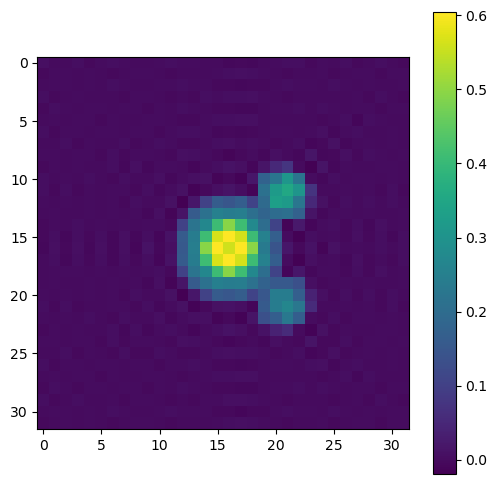

In [7]:
radius = 0.8
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'nn')

#slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(
#    project, x_grid, mask, "nn"
#)
s = 17
img = slice_obj.slice(0.1 * vol_fourier, [0, 0, 0], [0, 0], jnp.array([None]))
img_r = jnp.fft.fftshift(jnp.real(jnp.fft.ifft2((img.reshape([nx, nx])))))
plt.imshow(img_r)
plt.colorbar()

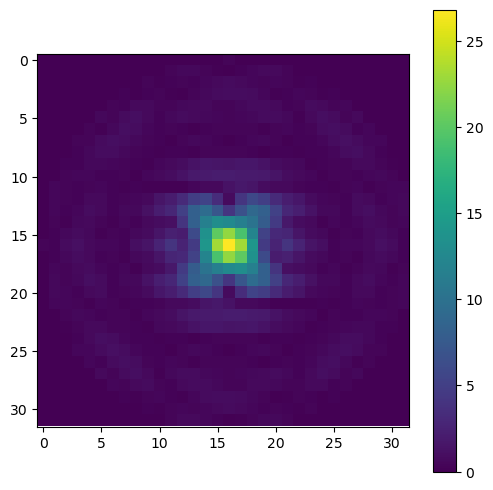

In [8]:
img_f0 = jnp.fft.fftshift(img.reshape([nx, nx]))
plt.imshow(jnp.abs(img_f0))
plt.colorbar()

Generate projections (in Fourier domain)

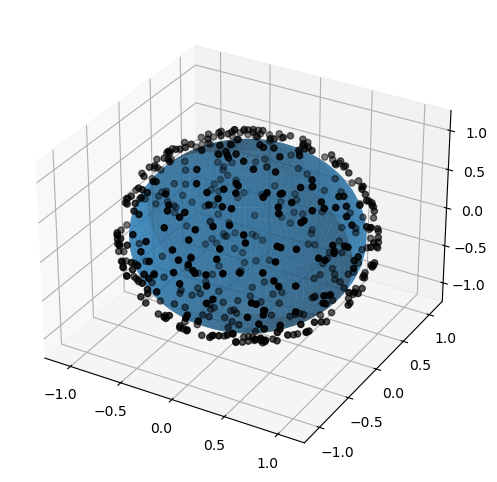

In [9]:
# Orientations
N = 5000

# s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
# jnp.array(np.random.rand(N,3))*jnp.pi*2

# angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
# angles_true = s*np.random.randn(int(N),3)
# angles_true = np.concatenate([s*np.random.randn(2250,3),
#                             s*np.random.randn(2250,3)+np.pi*2/3,
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
# np.random.shuffle(angles_true)
# angles_true = jnp.array(angles_true)

# angles_true = np.zeros([N,3])
# angles_true[:,1] = s*np.random.randn(N) - np.pi/2
# angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

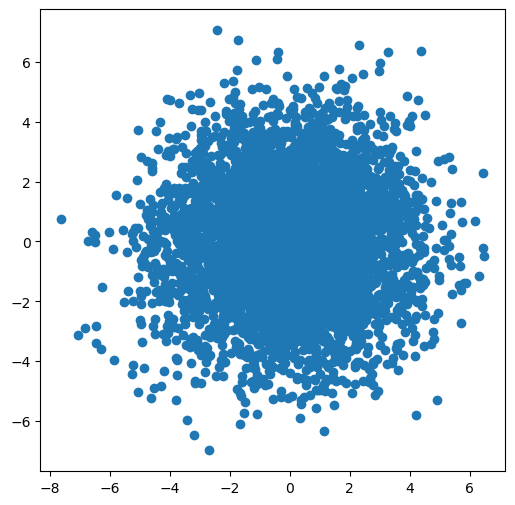

In [10]:
# Shifts
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
key, subkey = random.split(key)
# shifts_true = generate_uniform_shifts(key, N, pixel_size*nx/2)
shifts_true = generate_gaussian_shifts(key, N, pixel_size * nx / 10)

# shifts_true = jnp.zeros([N,3])

plt.scatter(shifts_true[:, 0], shifts_true[:, 1])

SNR = 0.15701089631017526
sigma = 37.84951113740295


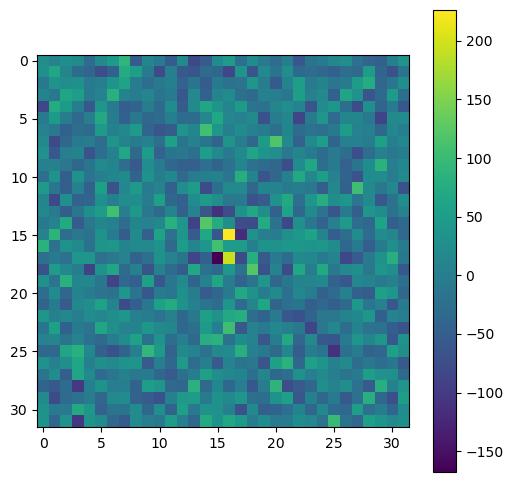

In [11]:
radius = 0.8
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'nn')

img0 = slice_obj.slice(vol_fourier, [0, 0, 0], [0, 0], ctf_params0)


ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_obj.slice_array(vol_fourier, angles_true, shifts_true, ctf_params)

# If too many images which don't fit in the gpu memory, do this:
# imgs = jnp.array([slice_func(vol_fourier, angles_true[i], shifts_true[i], ctf_params0) for i in range(N)])

norm0sq = jnp.real(jnp.sum(jnp.conj(imgs) * imgs))

# Noise
sigma = 0.2 * jnp.max(jnp.abs(img0))
imgs += (np.random.randn(N, nx * nx) + 1j * np.random.randn(N, nx * nx)) * sigma

norm1sq = jnp.real(jnp.sum(jnp.conj(imgs) * imgs))

# print(time.time()-start)

# SNR
print("SNR =", norm0sq / norm1sq)
print("sigma =", sigma)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[101].reshape(nx, nx))))
plt.colorbar()

### Crop images and volume:

In [12]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx * nx)
    # imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

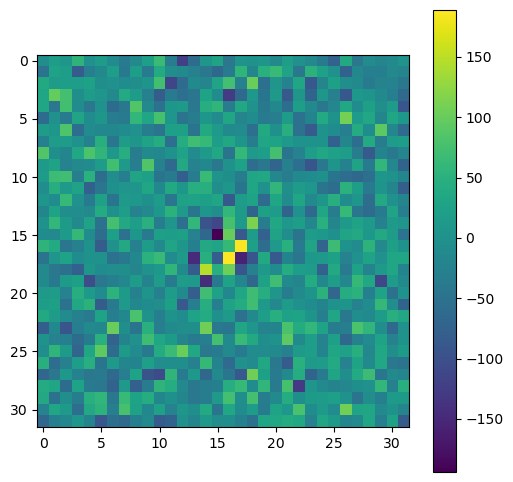

In [13]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx, nx))))
plt.colorbar()

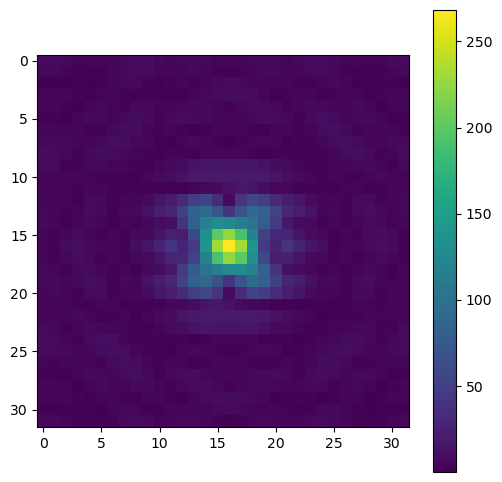

In [14]:
# mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:, :, 0]))))
plt.colorbar()

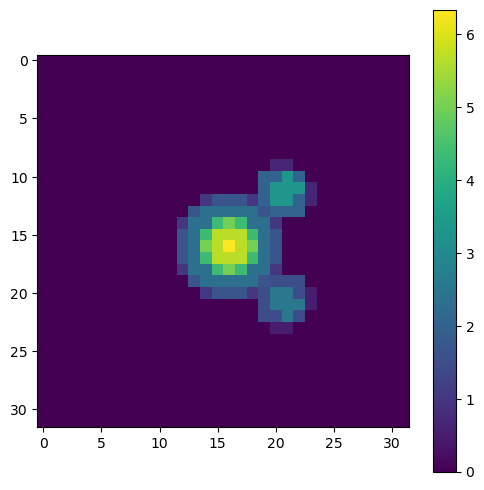

In [15]:
# mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:, :, 0]))))
plt.colorbar()

### Loss functions for the new dimension

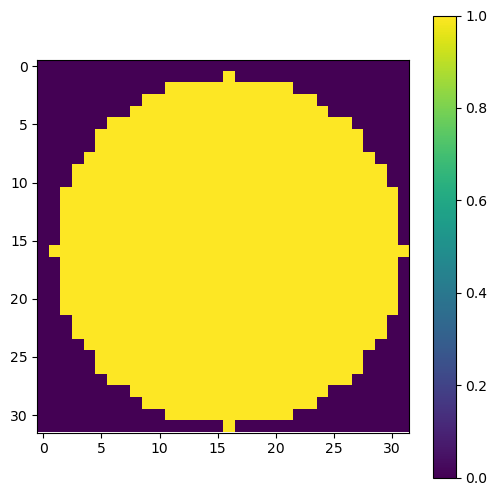

In [16]:
alpha = 0.01
# alpha = 1/N

#radius = 0.2 # for nx =8
# radius = 0.4 # for nx=16
radius = 0.75  # for nx=32
# radius = 1.6 # for nx=64
# radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
mip_z(jnp.fft.fftshift(mask))
plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'tri')
loss_obj = Loss(slice_obj, alpha=alpha)
grad_obj = GradV(loss_obj)

In [17]:
sigma_noise = jnp.ones(nx * nx) * sigma

In [18]:
start = time.time()
ll = loss_obj.loss_batched(
    vol_fourier,
    angles_true[:20],
    shifts_true[:20],
    ctf_params[:20],
    imgs[:20],
    sigma_noise,
)
print(time.time() - start)
print(ll.shape)

1.0901448726654053
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [19]:
start = time.time()
ll = grad_obj.grad_loss_volume(
    np.random.randn(nx, nx, nx),
    angles_true[0],
    shifts_true[0],
    ctf_params[0],
    imgs[0],
    sigma_noise,
)
print(time.time() - start)
print(ll.shape)

0.9512321949005127
(32, 32, 32)


In [20]:
batch_size = N
idx = np.random.default_rng().choice(N, size=batch_size, replace=False)

start = time.time()
ll = grad_obj.grad_loss_volume_sum(
    np.random.randn(nx, nx, nx),
    angles_true[idx],
    shifts_true[idx],
    ctf_params[idx],
    imgs[idx],
    sigma_noise,
)
print(time.time() - start)
print(ll.shape)

1.7062959671020508
(32, 32, 32)


### Set up the CryoProposals object for MCMC sampling

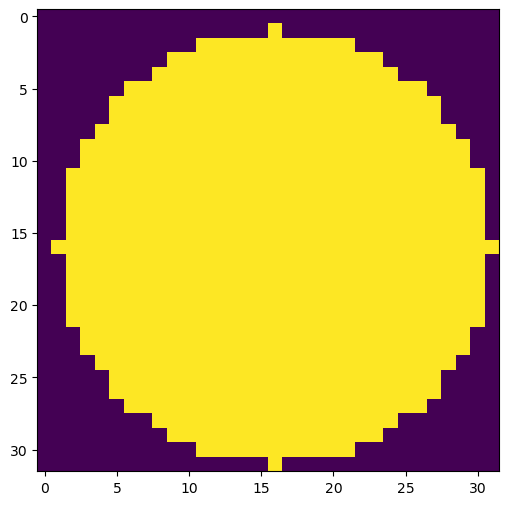

In [21]:
alpha0 = 0
B = pixel_size * nx / 10
B_list = jnp.array([B])
radius_mask = 0.75  # for nx=32
mask = create_3d_mask(x_grid, (0, 0, 0), radius_mask)
dt_list = jnp.array([0.5])
L_hmc = 10
M = 1

slice_obj = Slice(x_grid, mask, project, interp_method = 'tri')
loss_obj = Loss(slice_obj, alpha=alpha)
grad_obj = GradV(loss_obj)

cryo_proposals = CryoProposals(1, B, B_list, dt_list, L_hmc, M, slice_obj, loss_obj, grad_obj)

mip_z(jnp.fft.fftshift(mask))

### MCMC - volume

In [22]:
def plot_true_vs_estimated(vol_true, vol_estimated):
    plt.rcParams["figure.figsize"] = 16, 16
    plt.subplot(2, 2, 1)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_true[:, :, 0])))
    plt.colorbar()
    plt.title("True")
    plt.subplot(2, 2, 2)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_estimated[:, :, 0])))
    plt.colorbar()
    plt.title("Estimated")
    plt.subplot(2, 2, 3)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_true[:, :, 0]))))
    plt.colorbar()
    plt.title("True")
    plt.subplot(2, 2, 4)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_estimated[:, :, 0]))))
    plt.colorbar()
    plt.title("Estimated")

    plt.rcParams["figure.figsize"] = 8, 8

In [23]:
N_mc_samples = 200

key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
v0 = jnp.array(np.random.randn(nx, nx, nx) + 1j * np.random.randn(nx, nx, nx))

proposal_params = {
    'angles' : angles_true,
    'shifts' : shifts_true,
    'ctf_params' : ctf_params,
    'imgs' : imgs
}
t0 = time.time()
v_hmc_mean, r_hmc, v_hmc_samples = mcmc_sampling(
    key, 
    cryo_proposals.proposal_vol, 
    v0, 
    N_mc_samples, 
    proposal_params,
    verbose=True,
    iter_display=10
)
print((time.time() - t0) / N_mc_samples)
v_hmc_mean = v_hmc_mean * mask

  MCMC sample 10, posterior val = -1512265.83872328, a = 1.0
  MCMC sample 20, posterior val = -1512254.0179312618, a = 1.0
  MCMC sample 30, posterior val = -1512198.8763635983, a = 0.9194574714547611
  MCMC sample 40, posterior val = -1512255.4033760568, a = 1.0
  MCMC sample 50, posterior val = -1512431.0470848742, a = 1.0
  MCMC sample 60, posterior val = -1512347.412471502, a = 1.0
  MCMC sample 70, posterior val = -1512240.6184918387, a = 1.0
  MCMC sample 80, posterior val = -1512463.370457309, a = 0.9775033941864685
  MCMC sample 90, posterior val = -1512213.9365499476, a = 0.9992222773341473
  MCMC sample 100, posterior val = -1512428.2649102958, a = 1.0
  MCMC sample 110, posterior val = -1512350.9993622673, a = 0.8701196420914893
  MCMC sample 120, posterior val = -1512470.6101857156, a = 1.0
  MCMC sample 130, posterior val = -1512379.7786619822, a = 1.0
  MCMC sample 140, posterior val = -1512368.3275796848, a = 0.9658330746347886
  MCMC sample 150, posterior val = -151236

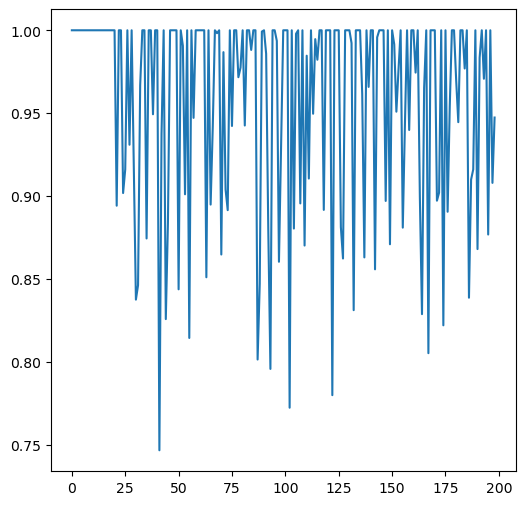

In [24]:
plt.plot(r_hmc)

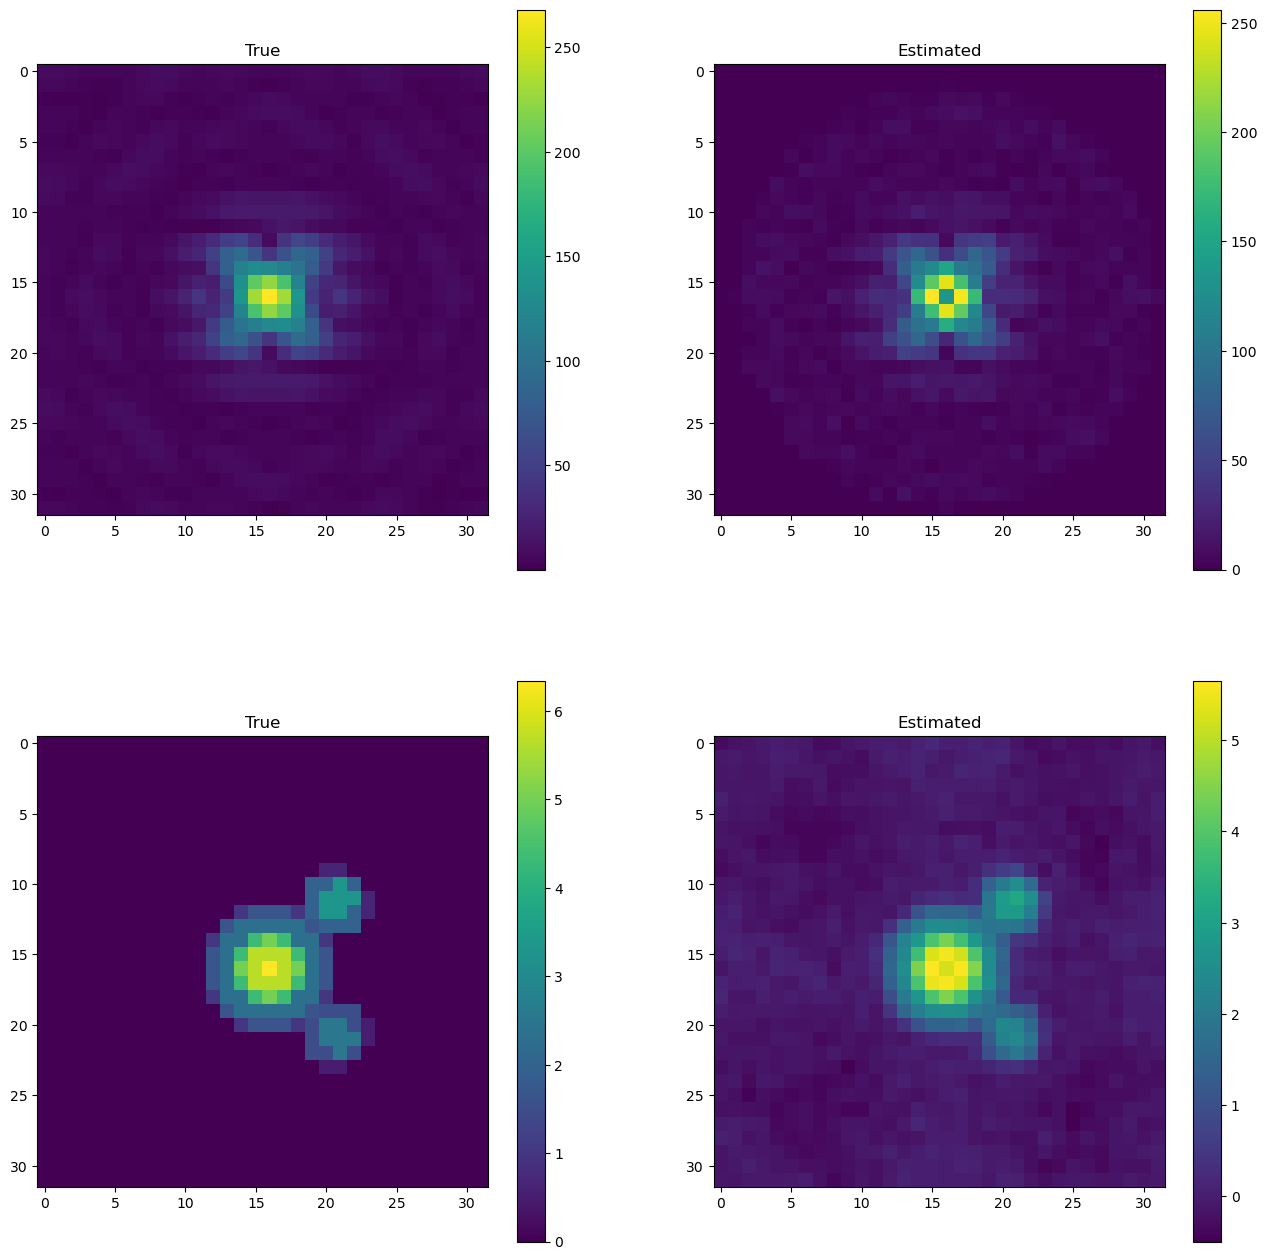

In [25]:
plot_true_vs_estimated(vol_fourier, v_hmc_mean)

In [26]:
print(loss_obj.loss_sum(vol_fourier, angles_true, shifts_true, ctf_params, imgs, 1))
print(loss_obj.loss_sum(v_hmc_mean, angles_true, shifts_true, ctf_params, imgs, 1))

1501445.996026156
1496265.5870512086


### MCMC - poses

### Orientations

In [27]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
N_mc_samples = 1001

angles0 = generate_uniform_orientations_jax(key, angles_true)
angles_proposal_params = {
    'v' : vol_fourier,
    'shifts' : shifts_true,
    'ctf_params' : ctf_params,
    'imgs' : imgs
}

_, r_angles, angles_samples = mcmc_sampling(
    key, 
    cryo_proposals.proposal_orientations_uniform, 
    angles0, 
    N_mc_samples, 
    angles_proposal_params,
    N_batch=N,
    verbose=True,
    iter_display=20
)

print(time.time() - t0)

angles_rec = angles_samples[0]

  MCMC sample 20, posterior val = -1522884.017091747
  MCMC sample 40, posterior val = -1514402.8250740322
  MCMC sample 60, posterior val = -1509932.1090331473
  MCMC sample 80, posterior val = -1506946.79207524
  MCMC sample 100, posterior val = -1504785.6374972092
  MCMC sample 120, posterior val = -1503081.545381392
  MCMC sample 140, posterior val = -1501741.8360137292
  MCMC sample 160, posterior val = -1500563.4245738848
  MCMC sample 180, posterior val = -1499632.0440289795
  MCMC sample 200, posterior val = -1498885.1482946351
  MCMC sample 220, posterior val = -1498118.2213081499
  MCMC sample 240, posterior val = -1497470.4935621251
  MCMC sample 260, posterior val = -1496871.838315075
  MCMC sample 280, posterior val = -1496354.442317511
  MCMC sample 300, posterior val = -1495808.168175396
  MCMC sample 320, posterior val = -1495366.0901484594
  MCMC sample 340, posterior val = -1494927.9915085523
  MCMC sample 360, posterior val = -1494535.456893799
  MCMC sample 380, pos

In [28]:
print(jnp.max(jnp.abs(loss_obj.loss_sum(vol_fourier, angles0, shifts_true, ctf_params, imgs, 1))))
print(jnp.max(jnp.abs(loss_obj.loss_sum(vol_fourier, angles_rec, shifts_true, ctf_params, imgs, 1))))
print(jnp.max(jnp.abs(loss_obj.loss_sum(vol_fourier, angles_true, shifts_true, ctf_params, imgs, 1))))

1603355.2898189325
1510467.2078105554
1501445.996026156


### Shifts

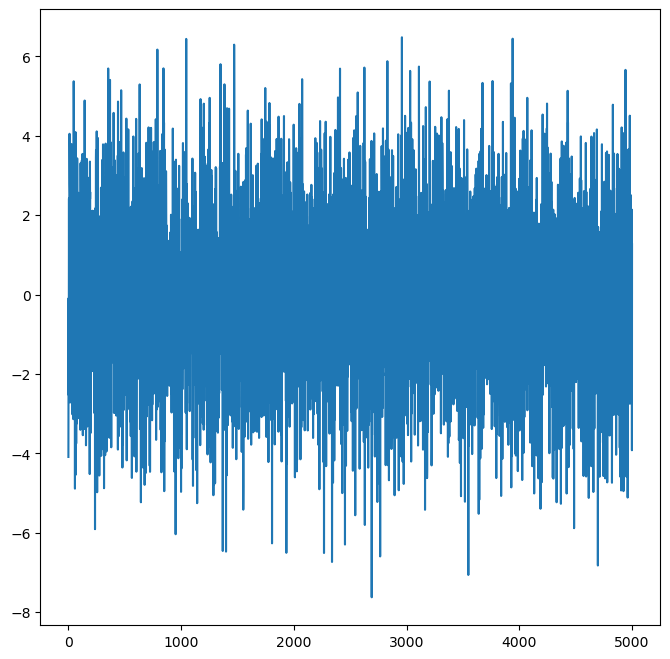

In [29]:
plt.plot(shifts_true[:,0])

In [30]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
N_mc_samples = 1001

shifts0 = generate_gaussian_shifts(key, N, cryo_proposals.B)
proj = slice_obj.rotate_and_interpolate_vmap(vol_fourier, angles_true)
shifts_proposal_params = {
    'v' : vol_fourier,
    'proj' : proj,
    'ctf_params' : ctf_params,
    'imgs' : imgs
}

t0 = time.time()

_, r_shifts, shifts_samples = mcmc_sampling(
    key, 
    cryo_proposals.proposal_shifts_local, 
    shifts0, 
    N_mc_samples, 
    shifts_proposal_params,
    N_batch=N,
    verbose=True,
    iter_display=20
)

print(time.time() - t0)

shifts_rec = shifts_samples[0]

  MCMC sample 20, posterior val = -1546439.6107498342
  MCMC sample 40, posterior val = -1514805.2900558445
  MCMC sample 60, posterior val = -1505518.3935450455
  MCMC sample 80, posterior val = -1501583.522653509
  MCMC sample 100, posterior val = -1499049.4730485827
  MCMC sample 120, posterior val = -1497119.5510923017
  MCMC sample 140, posterior val = -1495647.620048482
  MCMC sample 160, posterior val = -1494169.5976450727
  MCMC sample 180, posterior val = -1493200.2133485177
  MCMC sample 200, posterior val = -1492326.3333371144
  MCMC sample 220, posterior val = -1491677.2231735215
  MCMC sample 240, posterior val = -1491048.457209529
  MCMC sample 260, posterior val = -1490589.0445629056
  MCMC sample 280, posterior val = -1490225.5361143046
  MCMC sample 300, posterior val = -1489873.3684741764
  MCMC sample 320, posterior val = -1489511.8940541297
  MCMC sample 340, posterior val = -1489027.282656252
  MCMC sample 360, posterior val = -1488526.0198226904
  MCMC sample 380,

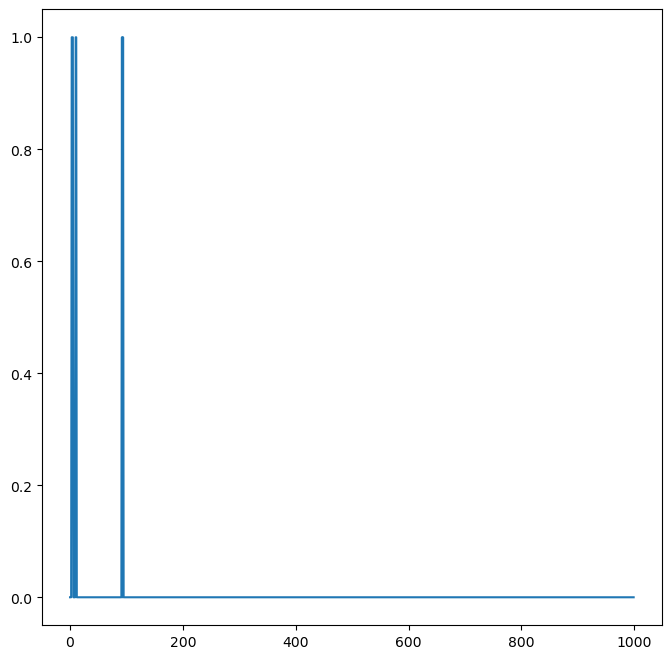

In [31]:
plt.plot(r_shifts[:,10])

mean shift0 error = 1.6384448340965025 in [ -2.0 , 2.0 ]^2
mean shift error = 0.5064841488384652 in [ -2.0 , 2.0 ]^2


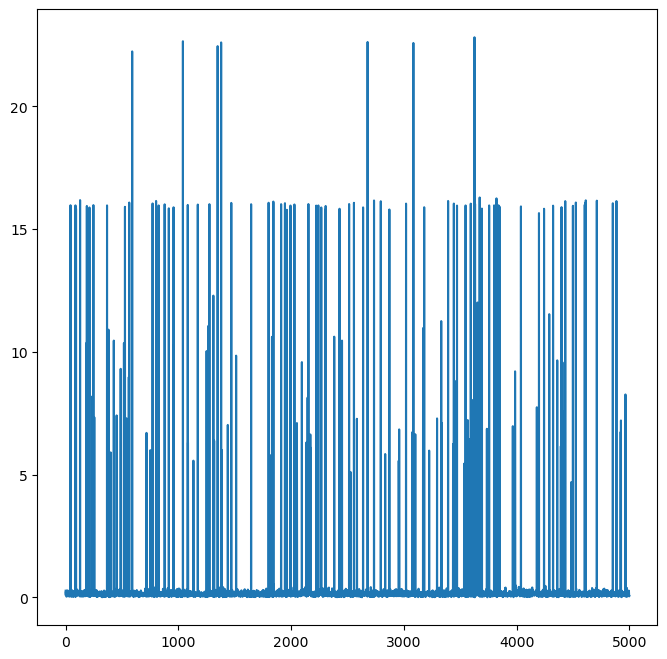

In [32]:
shifts0_err = wrap_around_distance_2d_array(shifts_true, shifts0, B)
shifts_err = wrap_around_distance_2d_array(shifts_true, shifts_rec, B)
print("mean shift0 error =", jnp.mean(shifts0_err), "in [", -B, ",", B, "]^2")
print("mean shift error =", jnp.mean(shifts_err), "in [", -B, ",", B, "]^2")
plt.plot(shifts_err)

### Ab initio reconstuction using MCMC sampling: volume+orientations+shifts

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

# It will stop when nx_iter=nx anyway, so setting N_iter large enough
N_iter = 200
N_batch = 1

dr = 0.05
radius = 0.2
alpha = 1e-7

sgd_batch_size = 500
learning_rate = 1

vol0 = None
angles0 = None
shifts0 = None

N_samples_vol = 501
N_samples_angles_global = 1001
N_samples_angles_local = 501
N_samples_shifts_global = 501
N_samples_shifts_local = 1001

# imgs_batch stays in RAM and only the current batch is processed on the GPU
imgs_batch = np.array(np.array_split(imgs, N_batch))
ctf_params_batch = jnp.array(np.array_split(ctf_params, N_batch))

# imgs_batch = imgs[None,:]
# ctf_params_batch = ctf_params[None,:]

eps_vol = 2e-5

# HMC params
dt_list = jnp.array([0.1, 0.5, 1, 5])
L = 10

# boundary for sampling shifts in [-B, B]^2
B = pixel_size * nx / 10

out_dir = "../data/ab_initio/"
imgs = imgs.reshape([N, nx * nx])
v_rec, angles_rec, shifts_rec = ab_initio_mcmc(
    key,
    imgs_batch,
    sigma_noise,
    ctf_params_batch,
    x_grid,
    vol0,
    angles0,
    shifts0,
    N_iter,
    learning_rate,
    sgd_batch_size,
    N_samples_vol,
    N_samples_angles_global,
    N_samples_angles_local,
    N_samples_shifts_global,
    N_samples_shifts_local,
    dt_list_hmc=dt_list,
    L_hmc=L,
    radius0=radius,
    dr = dr,
    alpha=alpha,
    eps_vol=eps_vol,
    B=B,
    B_list=jnp.array([B]),
    freq_marching_step_iters=1,
    interp_method="tri",
    opt_vol_first=True,
    verbose=True,
    save_to_file=False,
)

Fourier radius: 0.8
Minibatch factor: None
Starting radius: 0.2
Frequency marching step size: 0.05
Number of frequency marching steps: 13
Number of iterations: 13
B = 2.0
B_list = [2.]
------------------------------------

Initialitsing volume
Epoch 1/501 

100%|█████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=1.000e+00, grad=3.439e-02, loss=1.216e+03]


  |Grad| = 3.539e-02
  Loss = 1.21374049e+03
  eta = 1
  alpha = 1e-10
Epoch 101/501 

100%|█████████████████| 10/10 [00:00<00:00, 69.32it/s, eta=1.000e+00, grad=2.945e-02, loss=1.199e+03]

  |Grad| = 3.014e-02
  Loss = 1.19890176e+03
  eta = 1
  alpha = 1e-10


Epoch 201/501 

100%|█████████████████| 10/10 [00:00<00:00, 86.25it/s, eta=1.000e+00, grad=2.674e-02, loss=1.186e+03]

  |Grad| = 2.600e-02
  Loss = 1.18809421e+03
  eta = 1
  alpha = 1e-10


Epoch 301/501 

100%|█████████████████| 10/10 [00:00<00:00, 74.06it/s, eta=1.000e+00, grad=2.186e-02, loss=1.180e+03]

  |Grad| = 2.208e-02
  Loss = 1.18021956e+03
  eta = 1
  alpha = 1e-10


Epoch 401/501 

100%|█████████████████| 10/10 [00:00<00:00, 71.05it/s, eta=1.000e+00, grad=1.832e-02, loss=1.173e+03]

  |Grad| = 1.861e-02
  Loss = 1.17447885e+03
  eta = 1
  alpha = 1e-10


Epoch 501/501 

100%|█████████████████| 10/10 [00:00<00:00, 84.66it/s, eta=1.000e+00, grad=1.639e-02, loss=1.170e+03]

  |Grad| = 1.578e-02
  Loss = 1.17029086e+03
  eta = 1
  alpha = 1e-10


Iter 0
nx_iter = 9
Sampling global orientations and shifts
  MCMC sample 100, posterior val = -147.03734713084089
  MCMC sample 200, posterior val = -146.9955475189087
  MCMC sample 300, posterior val = -147.0263460693498
  MCMC sample 400, posterior val = -147.01063646443626
  MCMC sample 500, posterior val = -146.99318977164626
  MCMC sample 600, posterior val = -147.00628220424764
  MCMC sample 700, posterior val = -147.02121965424652
  MCMC sample 800, posterior val = -147.02968276541196
  MCMC sample 900, posterior val = -147.03801716692723
  MCMC sample 1000, posterior val = -147.03374231616516
  Time global orientations and shifts sampling = 54.74250364303589
  mean(a_angles_shifts) = 0.8180170793810492
Sampling local orientations
  MCMC sample 100, posterior val = -144.32510812756027
  MCMC sample 200, posterior val = -144.27683968834333
  MCMC sample 300, posterior val = -144.21999297849135
  MCMC sample 400, posterior val = -144.25395415580417
  MCMC sample 500, posterior val

In [ ]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec[:, :, 0]))))
plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:, :, 0])))
plt.colorbar()

In [ ]:
plot_angles(angles_rec[0,:1000])

In [ ]:
shifts_err = wrap_around_distance_2d_array(shifts_true, shifts_rec[0], 10)
print("mean shift error =", jnp.mean(shifts_err), "in [", -10, ",", 10, "]^2")
plt.plot(shifts_err)

In [ ]:
plot_angles(angles_true[:1000])